In [5]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import yfinance as yf

# First try

In [7]:
ticker = "SPY"
df = yf.download(ticker, start="2020-01-01", end="2025-01-01")
df['return'] = df['Close'].pct_change()
df['ma_5'] = df['Close'].rolling(5).mean()
df['ma_20'] = df['Close'].rolling(20).mean()
df['volatility'] = df['return'].rolling(20).std()
df = df.dropna()

features = df[['return','ma_5','ma_20','volatility']].values.astype(np.float32)
returns = df['return'].values.astype(np.float32)

# Normalisation
features_mean = features.mean(axis=0)
features_std = features.std(axis=0)
features = (features - features_mean) / (features_std + 1e-8)

/var/folders/nk/kpj6413n2lj1cln9c1z0_pj80000gn/T/ipykernel_3786/4267352491.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start="2020-01-01", end="2025-01-01")
[*********************100%***********************]  1 of 1 completed


In [8]:
class TradingEnv:
    def __init__(self, features, returns):
        self.features = features
        self.returns = returns
        self.reset()
    
    def reset(self):
        self.t = 0
        self.done = False
        self.pnl = 0.0
        return self.features[self.t]
    
    def step(self, action):
        """
        action = -1 (short), 0 (flat), 1 (long)
        """
        r = self.returns[self.t]
        reward = action * r
        self.pnl += reward
        self.t += 1
        if self.t >= len(self.returns):
            self.done = True
        obs = self.features[self.t] if not self.done else np.zeros_like(self.features[0])
        return obs, reward, self.done

In [9]:
class PolicyRNN(nn.Module):
    def __init__(self, input_dim, hidden_dim=32, output_dim=3):
        super().__init__()
        self.rnn = nn.GRU(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x, h=None):
        """
        x: [batch, seq_len, input_dim]
        returns: logits, hidden
        """
        out, h = self.rnn(x, h)
        logits = self.fc(out[:,-1,:])  # dernière sortie
        return logits, h

In [10]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
input_dim = features.shape[1]
policy = PolicyRNN(input_dim).to(device)
optimizer = optim.Adam(policy.parameters(), lr=1e-3)

# Hyperparams
epochs = 50
gamma = 0.99

env = TradingEnv(features, returns)

for ep in range(epochs):
    obs = env.reset()
    h = None
    log_probs = []
    rewards = []
    
    while not env.done:
        x = torch.tensor(obs, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)  # [1,1,input_dim]
        logits, h = policy(x, h)
        probs = torch.softmax(logits, dim=-1)
        dist = torch.distributions.Categorical(probs)
        action = dist.sample()
        log_prob = dist.log_prob(action)
        # map 0,1,2 -> -1,0,1
        action_mapped = action.item() - 1
        
        obs, reward, done = env.step(action_mapped)
        
        log_probs.append(log_prob)
        rewards.append(reward)
    
    # compute returns
    returns_t = []
    R = 0
    for r in reversed(rewards):
        R = r + gamma * R
        returns_t.insert(0, R)
    returns_t = torch.tensor(returns_t, dtype=torch.float32).to(device)
    
    log_probs = torch.stack(log_probs)
    loss = -torch.sum(log_probs * returns_t)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (ep+1)%5==0:
        print(f"Epoch {ep+1}, PnL: {env.pnl:.4f}")


Epoch 5, PnL: -0.0516
Epoch 10, PnL: 0.0905
Epoch 15, PnL: 0.1514
Epoch 20, PnL: -0.4106
Epoch 25, PnL: 0.2009
Epoch 30, PnL: 0.2428
Epoch 35, PnL: 0.1818
Epoch 40, PnL: 1.1660
Epoch 45, PnL: 0.8088
Epoch 50, PnL: 0.5740


In [11]:
env = TradingEnv(features, returns)
obs = env.reset()
h = None
pnl_list = []
actions_list = []

while not env.done:
    x = torch.tensor(obs, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
    logits, h = policy(x, h)
    probs = torch.softmax(logits, dim=-1)
    action = torch.argmax(probs, dim=-1).item() - 1
    actions_list.append(action)
    obs, reward, done = env.step(action)
    pnl_list.append(env.pnl)

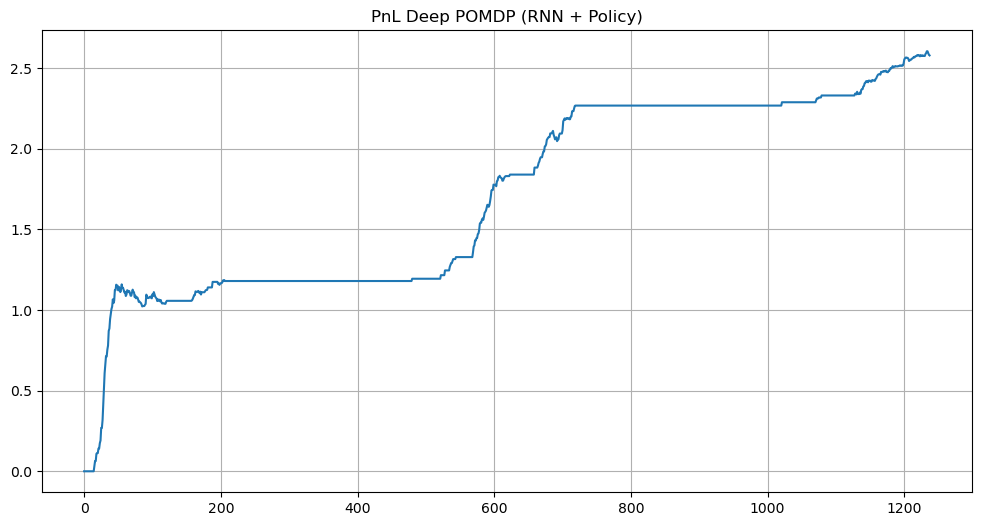

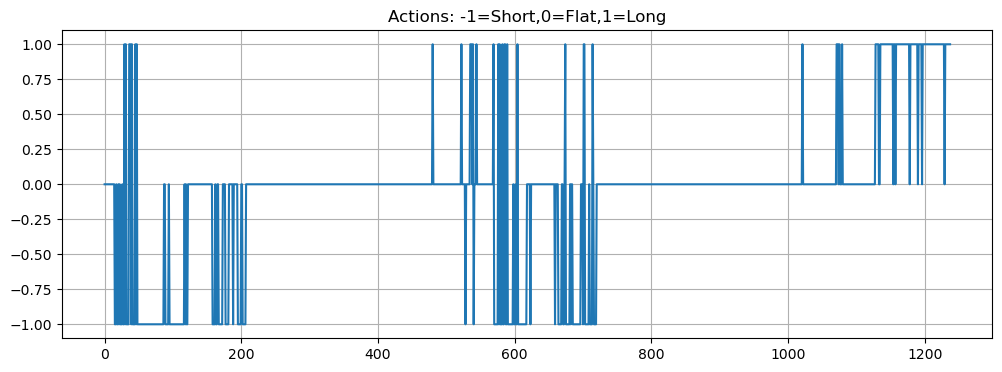

In [12]:
plt.figure(figsize=(12,6))
plt.plot(pnl_list)
plt.title("PnL Deep POMDP (RNN + Policy)")
plt.grid()
plt.show()

plt.figure(figsize=(12,4))
plt.plot(actions_list)
plt.title("Actions: -1=Short,0=Flat,1=Long")
plt.grid()
plt.show()

# Enriched data

In [13]:
ticker = "SPY"
df = yf.download(ticker, start="2020-01-01", end="2025-01-01")
df['return'] = df['Close'].pct_change()
df['ma_5'] = df['Close'].rolling(5).mean()
df['ma_20'] = df['Close'].rolling(20).mean()
df['volatility'] = df['return'].rolling(20).std()
df['volume_norm'] = (df['Volume'] - df['Volume'].mean()) / df['Volume'].std()
df['momentum_5'] = df['Close'].diff(5)
df['ema_12'] = df['Close'].ewm(span=12).mean()
df['ema_26'] = df['Close'].ewm(span=26).mean()
df['bb_dist'] = (df['Close'] - df['Close'].rolling(20).mean()) / df['Close'].rolling(20).std()
df = df.dropna()

/var/folders/nk/kpj6413n2lj1cln9c1z0_pj80000gn/T/ipykernel_3786/3370889111.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start="2020-01-01", end="2025-01-01")
[*********************100%***********************]  1 of 1 completed


In [14]:
features = df[['return','ma_5','ma_20','volatility','volume_norm','momentum_5','ema_12','ema_26','bb_dist']].values.astype(np.float32)
returns = df['return'].values.astype(np.float32)

In [15]:
# Normalisation
features_mean = features.mean(axis=0)
features_std = features.std(axis=0)
features = (features - features_mean) / (features_std + 1e-8)

In [16]:
class TradingEnv:
    def __init__(self, features, returns):
        self.features = features
        self.returns = returns
        self.reset()
    
    def reset(self):
        self.t = 0
        self.done = False
        self.pnl = 0.0
        return self.features[self.t]
    
    def step(self, action):
        r = self.returns[self.t]
        # reward shaping : pénalisation du risque
        reward = action * r - 0.1 * abs(action * r)
        self.pnl += reward
        self.t += 1
        if self.t >= len(self.returns):
            self.done = True
        obs = self.features[self.t] if not self.done else np.zeros_like(self.features[0])
        return obs, reward, self.done

In [17]:
class PPOAgent(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, action_dim=3):
        super().__init__()
        self.rnn = nn.GRU(input_dim, hidden_dim, batch_first=True)
        self.policy_head = nn.Linear(hidden_dim, action_dim)
        self.value_head = nn.Linear(hidden_dim, 1)
    
    def forward(self, x, h=None):
        out, h = self.rnn(x, h)
        last_out = out[:,-1,:]
        logits = self.policy_head(last_out)
        value = self.value_head(last_out)
        return logits, value, h

In [18]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
env = TradingEnv(features, returns)
input_dim = features.shape[1]
agent = PPOAgent(input_dim).to(device)
optimizer = optim.Adam(agent.parameters(), lr=1e-3)

epochs = 50
gamma = 0.99
eps_clip = 0.2

for ep in range(epochs):
    obs = env.reset()
    h = None
    log_probs = []
    values = []
    rewards = []
    states = []
    actions_list = []
    
    # Collect trajectory
    while not env.done:
        x = torch.tensor(obs, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)  # [1,1,input_dim]
        logits, value, h = agent(x, h)
        probs = torch.softmax(logits, dim=-1)
        dist = torch.distributions.Categorical(probs)
        action = dist.sample()
        log_prob = dist.log_prob(action)
        action_mapped = action.item() - 1
        
        obs, reward, done = env.step(action_mapped)
        
        log_probs.append(log_prob)
        values.append(value.squeeze())
        rewards.append(reward)
        states.append(x)
        actions_list.append(action_mapped)
    
    # Compute discounted returns
    returns_t = []
    R = 0
    for r in reversed(rewards):
        R = r + gamma * R
        returns_t.insert(0, R)
    returns_t = torch.tensor(returns_t, dtype=torch.float32).to(device)
    values = torch.stack(values)
    log_probs = torch.stack(log_probs)
    
    # Advantages
    advantages = returns_t - values.detach()
    
    # PPO loss
    ratio = torch.exp(log_probs - log_probs.detach())  # simple approx
    surr1 = ratio * advantages
    surr2 = torch.clamp(ratio, 1-eps_clip, 1+eps_clip) * advantages
    policy_loss = -torch.min(surr1, surr2).mean()
    value_loss = nn.MSELoss()(values, returns_t)
    loss = policy_loss + 0.5*value_loss
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (ep+1)%5==0:
        print(f"Epoch {ep+1}, PnL: {env.pnl:.4f}")

Epoch 5, PnL: -0.8627
Epoch 10, PnL: -0.8448
Epoch 15, PnL: -0.7718
Epoch 20, PnL: -1.2216
Epoch 25, PnL: -0.8366
Epoch 30, PnL: -0.3238
Epoch 35, PnL: -0.3796
Epoch 40, PnL: -1.0177
Epoch 45, PnL: -0.3999
Epoch 50, PnL: -0.8367


In [19]:
env = TradingEnv(features, returns)
obs = env.reset()
h = None
pnl_list = []
actions_list = []

while not env.done:
    x = torch.tensor(obs, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
    logits, value, h = agent(x, h)
    probs = torch.softmax(logits, dim=-1)
    action = torch.argmax(probs, dim=-1).item() - 1
    actions_list.append(action)
    obs, reward, done = env.step(action)
    pnl_list.append(env.pnl)

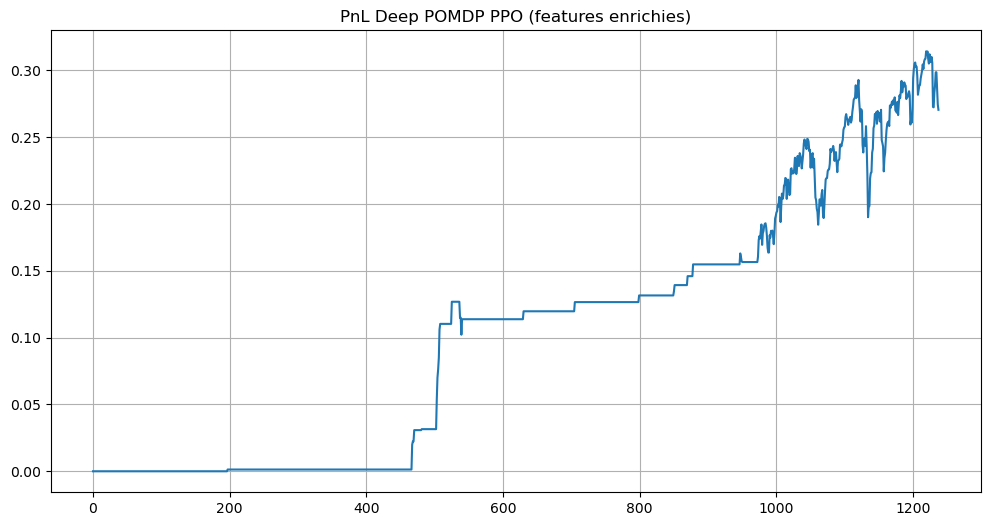

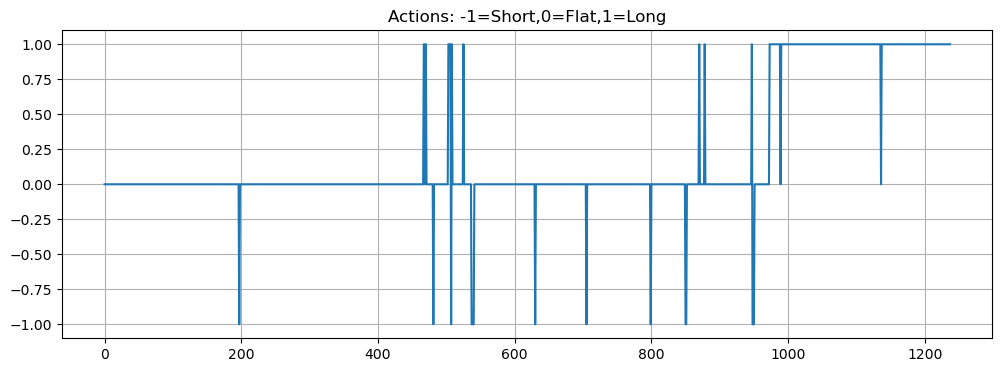

In [20]:
plt.figure(figsize=(12,6))
plt.plot(pnl_list)
plt.title("PnL Deep POMDP PPO (features enrichies)")
plt.grid()
plt.show()

plt.figure(figsize=(12,4))
plt.plot(actions_list)
plt.title("Actions: -1=Short,0=Flat,1=Long")
plt.grid()
plt.show()